# Experiment with different Models - part 3

-----

### Objective
The goal of this third notebook is to enhance the best-performing model from the previous notebook by incorporating super-resolution techniques using the [Real-ESRGAN Model](https://github.com/xinntao/Real-ESRGAN) on the dataset images. The aim is to evaluate and compare the results to determine if these adjustments lead to any improvements in model performance.

### Summary:
- **Set up**:  Prepare and load the data for model experimentation.
  
7) **Use images treated with Super Resolution**: Use the dataset with images enhanced through Super Resolution to improve input consistency for the model.
8) **Compare Results**: Evaluate the outcomes and determine the impact of the enhancements.




-----

## Set up:

### Import Libs

In [9]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
import os
import numpy as np
from glob import glob
import glob
import random
#import imageio
import imageio.v2 as imageio  # Explicitly use version 2 API
from torchvision import transforms
from collections import defaultdict

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torchmetrics import JaccardIndex

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import jaccard_score
from PIL import Image

from transformers import get_cosine_schedule_with_warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau

import re
import shutil

import importlib
import gc
import S7_tools

In [10]:
# Set the Multiprocessing Start Method for Windows
import torch.multiprocessing as mp

if __name__ == "__main__":
    mp.set_start_method('spawn', force=True)

# Set a known seed
seed = 23
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)


### CUDA configuration

In [12]:
print(70*'-')
print("CUDA available:", torch.cuda.is_available())
current_device = torch.cuda.current_device()
print("GPU Model:", torch.cuda.get_device_name(current_device))
print("CUDA Version:", torch.version.cuda)
print(70*'-')

device_properties = torch.cuda.get_device_properties(current_device)
print("\nDevice Properties:")
print("  Name:", device_properties.name)
print("  Total Memory (GB):", device_properties.total_memory / (1024 ** 3))  # Convert bytes to GB
print("  Multiprocessors:", device_properties.multi_processor_count)
print("  Compute Capability:", device_properties.major, ".", device_properties.minor)
print(70*'-')

----------------------------------------------------------------------
CUDA available: True
GPU Model: NVIDIA GeForce GTX 1080 Ti
CUDA Version: 11.8
----------------------------------------------------------------------

Device Properties:
  Name: NVIDIA GeForce GTX 1080 Ti
  Total Memory (GB): 10.999755859375
  Multiprocessors: 28
  Compute Capability: 6 . 1
----------------------------------------------------------------------


# 7- Use images treated with Super Resolution

## 7.1- Super Resolution: Real-ESRGAN with 2x scale (upscale from 256x256 to 512x512)

## Data Access

In [20]:
# Function to extract the numeric value from filenames
def numeric_sort_key(filepath):
    # Extract numbers from the filename using a regular expression
    match = re.search(r'\d+', filepath)
    # Return the integer value of the number if found, otherwise 0
    return int(match.group()) if match else 0

# Get all the image and mask paths and sort them numerically
folder_data_train = sorted(
    glob.glob("../5-Data_Wrangling/data_split2esr/train/input/*tif"),
    key=numeric_sort_key
)
folder_mask_train = sorted(
    glob.glob("../5-Data_Wrangling/data_split2esr/train/labels/*tif"),
    key=numeric_sort_key
)

folder_data_val = sorted(
    glob.glob("../5-Data_Wrangling/data_split2esr/val/input/*tif"),
    key=numeric_sort_key
)
folder_mask_val = sorted(
    glob.glob("../5-Data_Wrangling/data_split2esr/val/labels/*tif"),
    key=numeric_sort_key
)

folder_data_test = sorted(
    glob.glob("../5-Data_Wrangling/data_split2esr/test/input/*tif"),
    key=numeric_sort_key
)
folder_mask_test = sorted(
    glob.glob("../5-Data_Wrangling/data_split2esr/test/labels/*tif"),
    key=numeric_sort_key
)

# Assign to variables
train_image_paths = folder_data_train[:]
val_image_paths = folder_data_val[:]
test_image_paths = folder_data_test[:]

train_mask_paths = folder_mask_train[:]
val_mask_paths = folder_mask_val[:]
test_mask_paths = folder_mask_test[:]


In [22]:
# Check the number of train, val and test images
print('\nControl number of images by folder:')
print(40*'=')
input_total = len(folder_data_train)+len(folder_data_val)+len(folder_data_test)
labels_total = len(folder_mask_train)+len(folder_mask_val)+len(folder_mask_test)
print('\t\tinput: \tlabels:')
print(f'Train\t\t{len(folder_data_train)}\t{len(folder_mask_train)}\t{(len(folder_data_train)/input_total)*100:.2f}%')
print(f'Val\t\t{len(folder_data_val)}\t{len(folder_mask_val)}\t{(len(folder_data_val)/input_total)*100:.2f}%')
print(f'Test\t\t{len(folder_data_test)}\t{len(folder_mask_test)}\t{(len(folder_data_test)/input_total)*100:.2f}%')
print(40*'=')
print(f'Total\t\t{input_total}\t{labels_total}')


Control number of images by folder:
		input: 	labels:
Train		201	201	73.90%
Val		35	35	12.87%
Test		36	36	13.24%
Total		272	272


### Custom Dataset

In [25]:
from torch.utils.data import get_worker_info

class CustomDataset(data.Dataset):
    def __init__(self, image_paths, target_paths, transform=None, band=None):

        self.image_paths = image_paths
        self.target_paths = target_paths
        self.transform = transform
        self.band = band # Specify which band to use (0: R, 1: G, 2: B, 3: NIR, None: all bands)
        self.scaler = MinMaxScaler() 
                
    def __getitem__(self, index):
         
        # Debugging: Get worker information
        worker_info = get_worker_info()
        if worker_info:
            print(f"Worker {worker_info.id} is processing index {index}")

        try:
            image = imageio.imread(self.image_paths[index]).astype(np.float32)
    
            # Select a specific band if specified
            if self.band is not None:
                image = image[:, :, self.band] #Select only the specified band
                image = image[:, :, np.newaxis]
                
            # Normalize the image
            image_reshaped = image.reshape(-1, image.shape[-1])
            image_scaled = self.scaler.fit_transform(image_reshaped)
            image = image_scaled.reshape(image.shape)
    
            # Reshape for MinMaxScaler and apply normalization
            image_reshaped = image.reshape(-1, 4)
            image_scaled = self.scaler.fit_transform(image_reshaped)
            image = image_scaled.reshape(image.shape)
            
            # Load the 1-band binary mask
            mask = imageio.imread(self.target_paths[index])
            mask = np.asarray(mask, dtype='float32')
            mask = np.where(mask>1, 0, mask) # some images has soil annotations as well
    
            # Debugging: Print shapes and types
            #print(f"Image shape: {image.shape}, dtype: {image.dtype}")
            #print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}")
    
            # Apply the transformation to both image and mask if self.transform is set
            if self.transform:
                image, mask = self.transform(image, mask)  # Pass both to transform if synchronized
    
            return image, mask
            
        except Exception as e:
            print(f"Error loading data at index {index} in worker {worker_info.id if worker_info else 'main process'}: {e}")
            raise e


    def __len__(self):

        return len(self.image_paths)

class ToTensor:
    def __call__(self, image, mask):
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Convert image to [C, H, W]
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add channel dimension for mask
        return image, mask


## 4- Data Augmentation

In [28]:
class SynchronizedTransform:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, mask):
        # Convert tensors to NumPy arrays if needed
        if isinstance(image, torch.Tensor):
            image = image.cpu().numpy()  # Move tensor to CPU and convert to NumPy array
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()  # Move tensor to CPU and convert to NumPy array
        
        # Convert numpy arrays to PIL images
        if image.ndim == 3 and image.shape[-1] == 1:  # Single-band images
            image = image.squeeze(-1)  # Remove the singleton channel
        image = Image.fromarray((image * 255).astype(np.uint8))  # Scale to 0-255
        mask = Image.fromarray((mask * 255).astype(np.uint8))

        for transform in self.transforms:
            if isinstance(transform, transforms.RandomHorizontalFlip):
                if torch.rand(1).item() < 0.5:
                    image = TF.hflip(image)
                    mask = TF.hflip(mask)
            elif isinstance(transform, transforms.RandomVerticalFlip):
                if torch.rand(1).item() < 0.5:
                    image = TF.vflip(image)
                    mask = TF.vflip(mask)
            elif isinstance(transform, transforms.RandomChoice):
                angle = random.choice([0, 90, 180, 270])
                image = TF.rotate(image, angle)
                mask = TF.rotate(mask, angle)
            elif isinstance(transform, transforms.ToTensor):
                image = TF.to_tensor(image)
                mask = TF.to_tensor(mask)

        return image, mask



In [30]:
simple_transform = SynchronizedTransform([
    transforms.ToTensor()  # Convert both image and mask to tensor
])

augmentation_transform = SynchronizedTransform([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.RandomChoice([
    #     transforms.RandomRotation(0),
    #     transforms.RandomRotation(90),
    #     transforms.RandomRotation(180),
    #     transforms.RandomRotation(270)
    # ]),
    transforms.ToTensor()
])

use_all_bands = True
model_band = None # 0:red, 1:green, 2:blue, 3:NIR, None:all 4 bands

train_dataset = CustomDataset(train_image_paths, train_mask_paths, transform=augmentation_transform, band=model_band)
val_dataset = CustomDataset(val_image_paths, val_mask_paths, transform=simple_transform, band=model_band)
test_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=simple_transform, band=model_band)



The previous code defines a `SynchronizedTransform` class and demonstrates its usage in applying synchronized transformations to both images and their corresponding masks in a semantic segmentation context. The `SynchronizedTransform` class ensures that when data augmentation or preprocessing steps are applied to an image, the exact same transformations are applied to the mask. This is crucial for maintaining the pixel-to-pixel correspondence between images and masks, which is essential for tasks like segmentation. The class accepts a list of transformations and applies them conditionally based on their type, such as horizontal or vertical flips, rotations, or tensor conversions.

In this implementation, two transformation pipelines are defined: `simple_transform` for basic preprocessing (converting images and masks to tensors) and `augmentation_transform` for more advanced data augmentation, including random horizontal flips, vertical flips, and tensor conversion. These transformations are then used to create training, validation, and testing datasets. The CustomDataset class is instantiated with appropriate transformations for each dataset, ensuring the training dataset benefits from augmentation to improve model generalization, while validation and testing datasets use simpler transformations to maintain consistency for evaluation. Additionally, the use_all_bands and model_band variables allow flexibility in working with multi-band satellite imagery, enabling the use of all bands or selecting specific ones (red, green, blue, or NIR).


### Control the synchronization of Data Augmentation transforms

In [34]:
def visualize_augmentations(dataset, num_samples=3):
    for i in range(num_samples):
        image, mask = dataset[i]
        
        # Display input image and mask side-by-side
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(image.permute(1, 2, 0))  # Convert CHW to HWC for display
        plt.title("Upscaled Image with ESR")
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask[0], cmap='gray')  # Show mask in grayscale
        plt.title("Upscaled Mask with NN")
        
        plt.show()

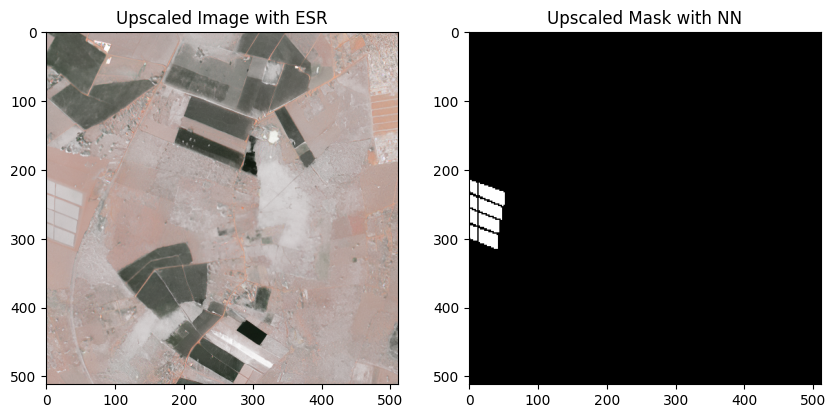

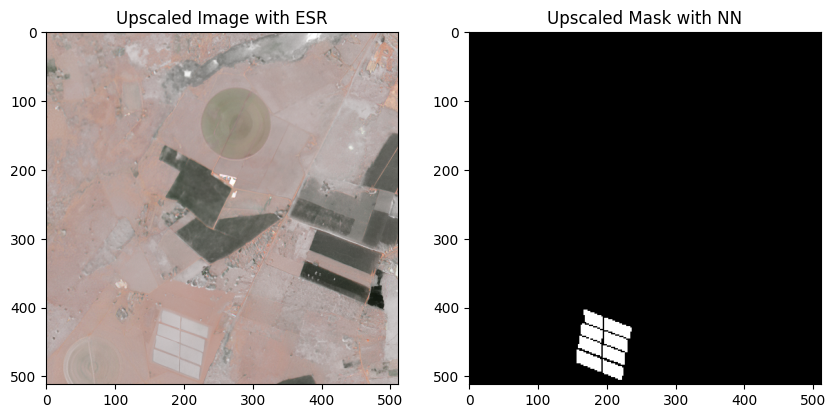

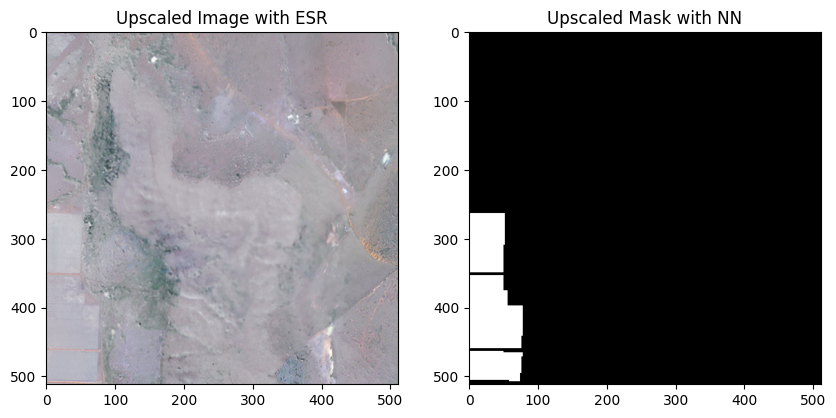

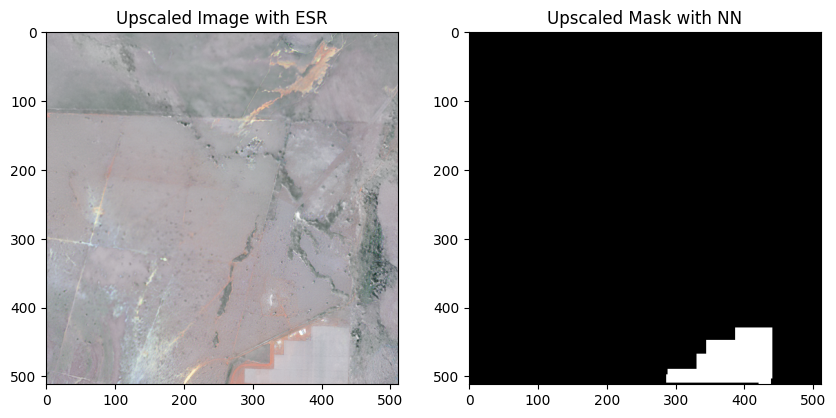

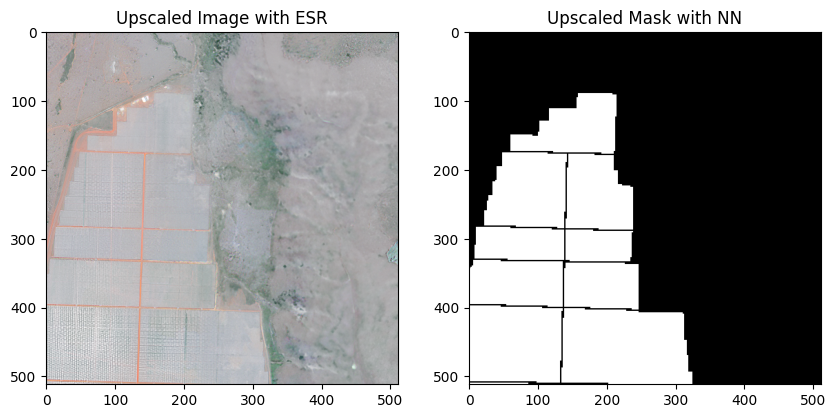

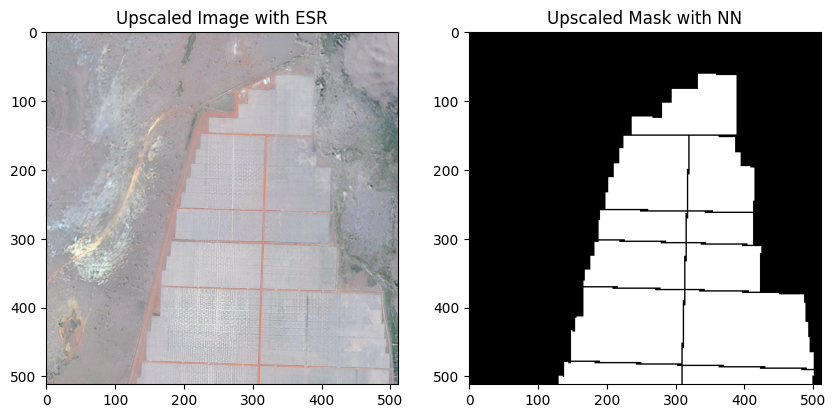

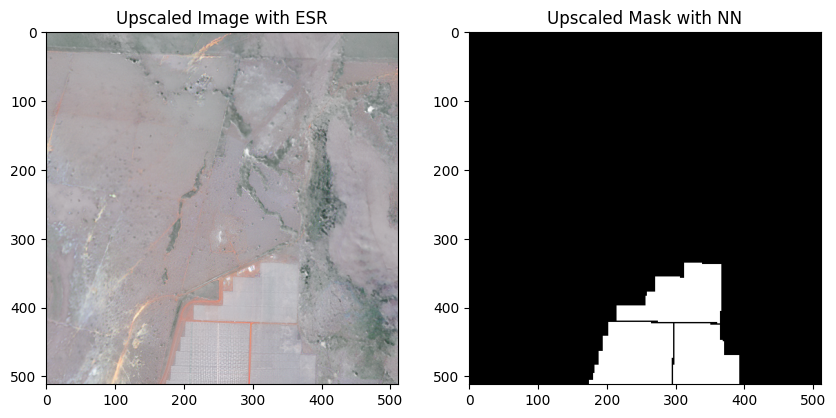

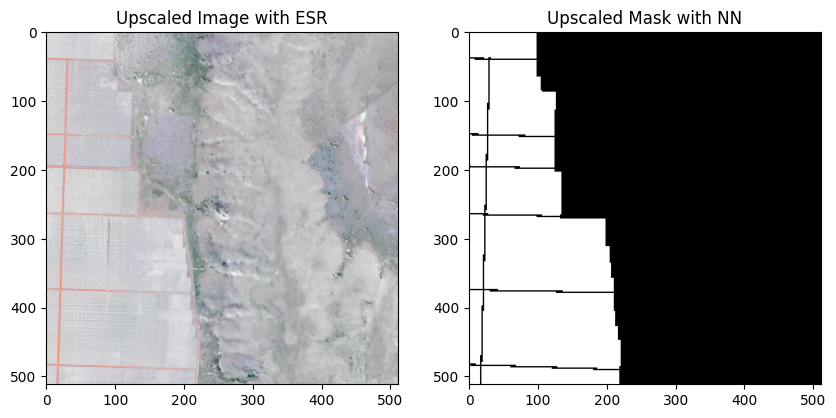

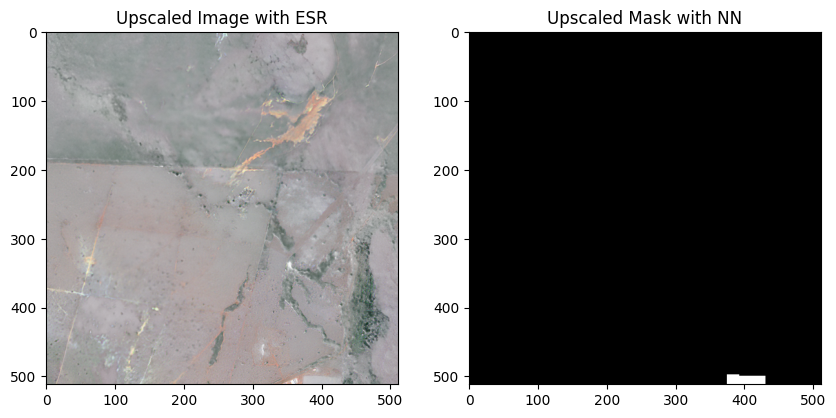

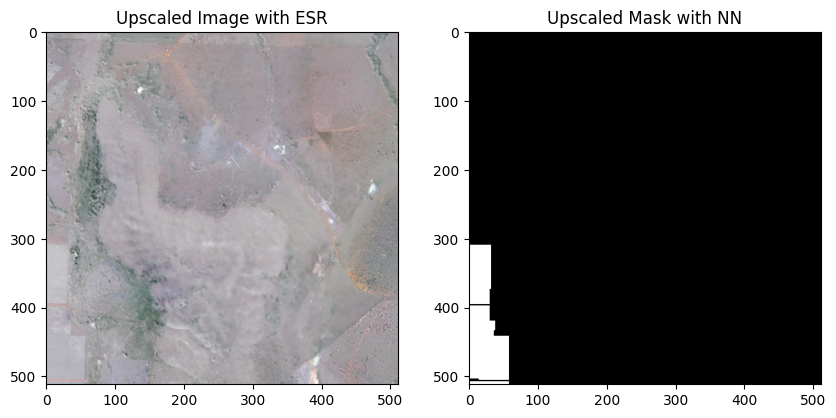

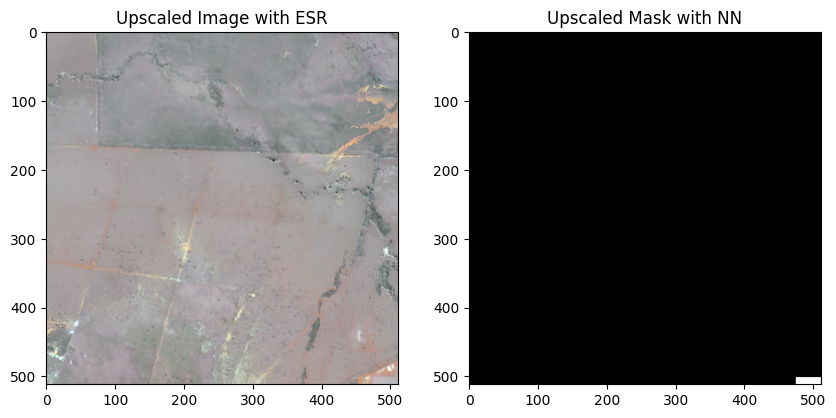

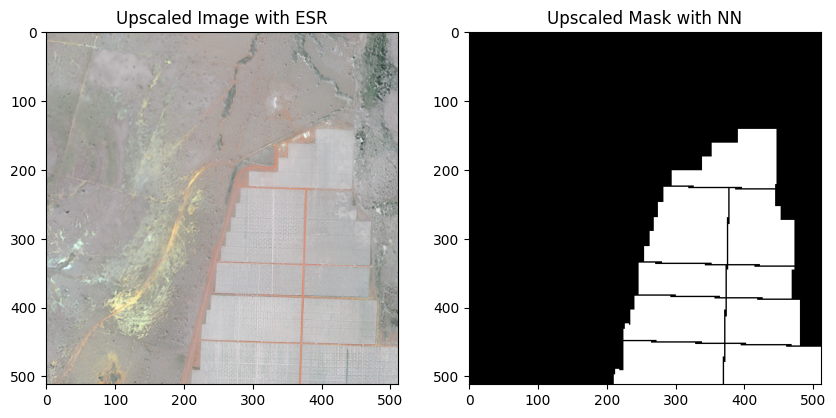

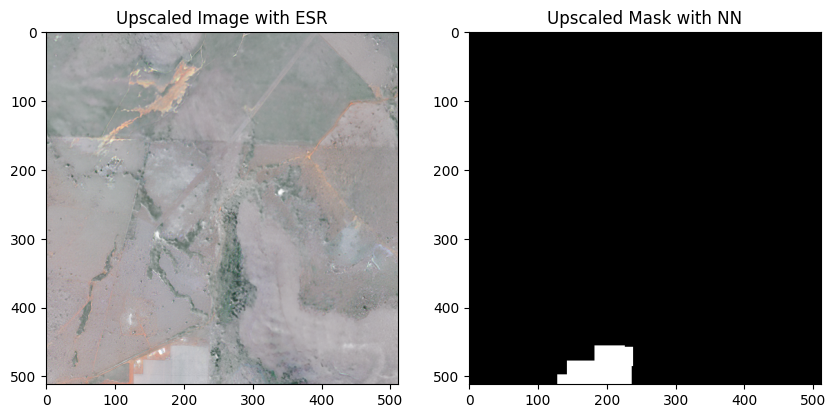

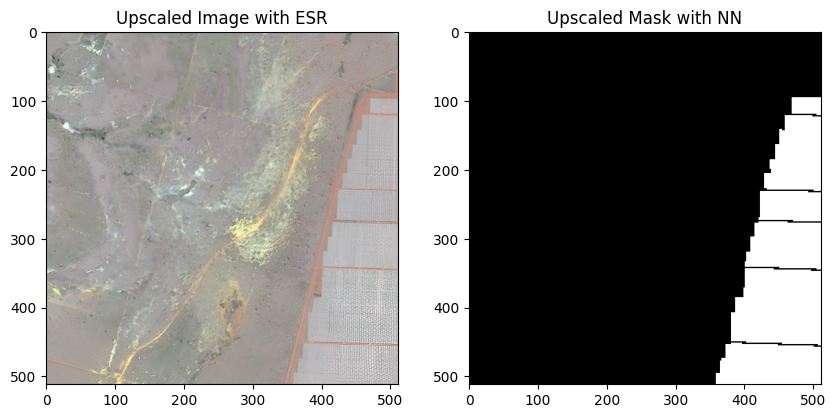

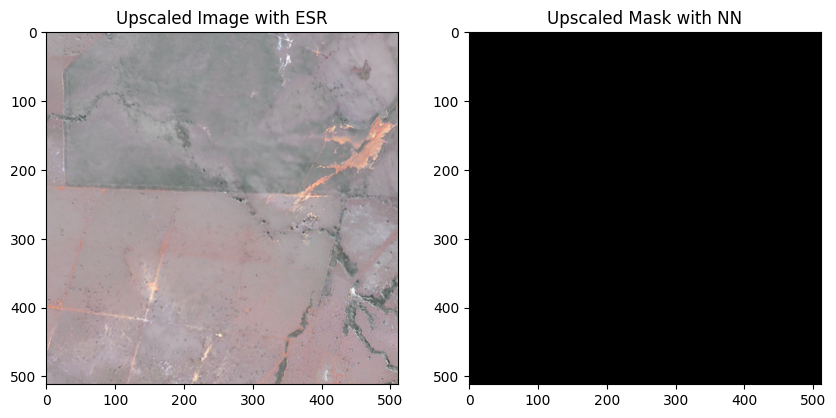

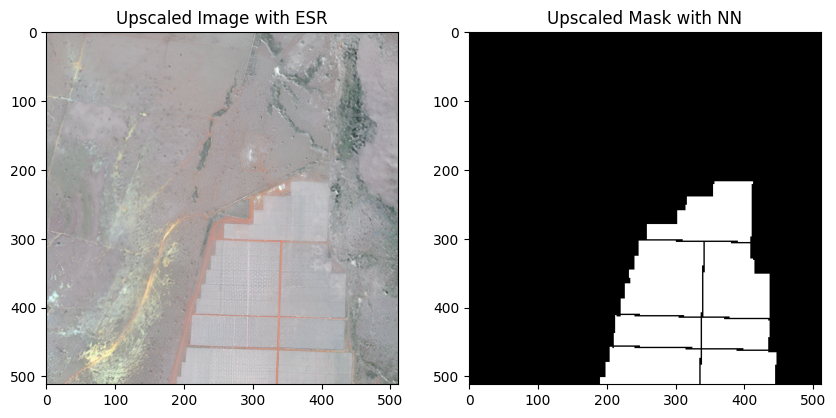

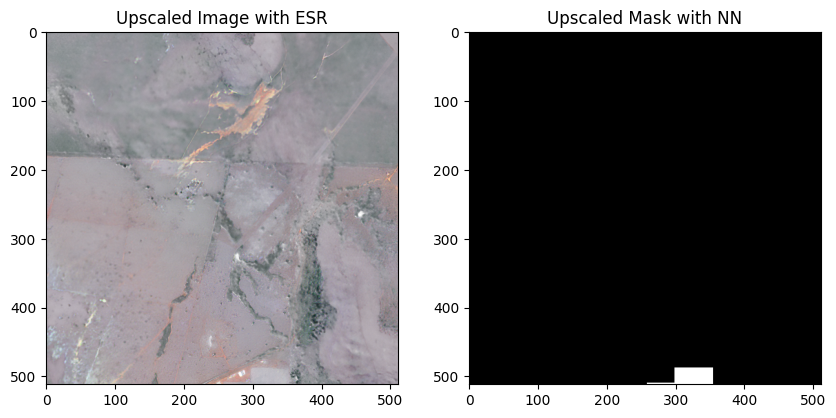

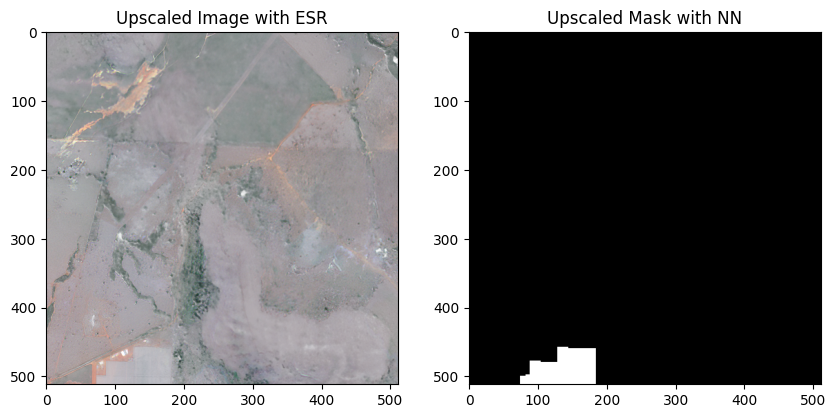

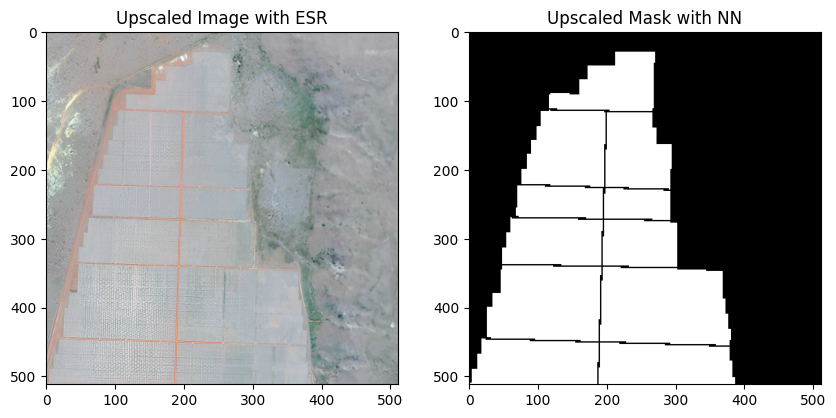

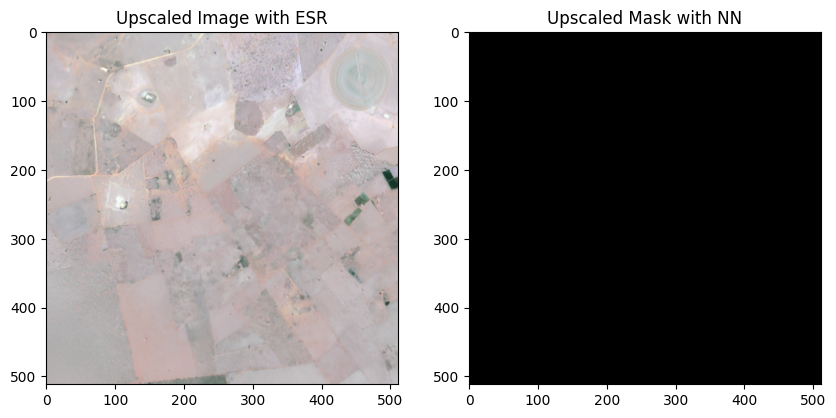

In [36]:
visualize_augmentations(test_dataset, num_samples=20)

This code defines a helper function, `visualize_augmentations`, to inspect the results of data augmentation applied to a dataset. The function ensures that the applied augmentations are synchronized between the input image and its corresponding mask, which is essential for semantic segmentation tasks. By visualizing the augmented image-mask pairs, we can verify that the transformations are applied correctly and consistently.

The function retrieves samples from the dataset, applies the defined augmentations, and visualizes the results side by side using Matplotlib. The image is displayed in its original color format (converted from PyTorch's CHW format to HWC for compatibility with Matplotlib), while the mask is shown in binary scale to emphasize segmentation boundaries. This visual inspection confirms that synchronization between the augmented image and mask is functioning correctly.


## Train the Selected Model with Data Augmentation

In [37]:
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['solar_panel']
ACTIVATION = 'sigmoid'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = smp.Unet(
    in_channels = 4 if use_all_bands else 1, #4 for all bands
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [38]:
importlib.reload(S7_tools)
from S7_tools import WeightedBCELoss, BCEFocalNegativeIoULoss, compute_class_aware_iou, train_loop, plot_loss_and_metrics



In [41]:
import gc  # For garbage collection

# Following, we incorporate these steps before start training a new model. 
# This helps optimize GPU memory usage and avoid potential slowdowns during subsequent training runs.

# Clear GPU memory
torch.cuda.empty_cache()
gc.collect()

# Reset GradScaler
scaler = torch.amp.GradScaler('cuda')

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=0.0001,               
    weight_decay=1e-6        
    )

loss = BCEFocalNegativeIoULoss(alpha=0.8, gamma=2)

# Adjusts every 'step_size' epochs, decreasing by 'gamma'*100 %
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Reset the dataset loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=5, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=40, shuffle=False, num_workers=0)

In [43]:
train_losses, train_ious, valid_losses, valid_ious, _, _ = \
train_loop(model = model, 
           train_loader = train_loader, 
           valid_loader = valid_loader, 
           test_loader = test_loader, 
           optimizer = optimizer, 
           loss = loss, 
           scheduler = scheduler, 
           early_stopping_patience = 20, 
           early_stopping_min_delta = 0.0001, 
           model_filename = './models/Unet_wDA&ESR_effb7.pth', 
           device = DEVICE)


Epoch: 0
Discard 0s? True	| 0s_masks/Tot_imgs: 32/201 	|| Train Loss: 0.149285 | Train IoU: 0.051
Discard 0s? True	| 0s_masks/Tot_imgs: 4/35 	|| Valid Loss: 0.144996 | Valid IoU: 0.088
Model saved!

Epoch: 1
Discard 0s? True	| 0s_masks/Tot_imgs: 32/201 	|| Train Loss: 0.112354 | Train IoU: 0.180
Discard 0s? True	| 0s_masks/Tot_imgs: 4/35 	|| Valid Loss: 0.123029 | Valid IoU: 0.080
Model saved!

Epoch: 2
Discard 0s? True	| 0s_masks/Tot_imgs: 32/201 	|| Train Loss: 0.090464 | Train IoU: 0.316
Discard 0s? True	| 0s_masks/Tot_imgs: 4/35 	|| Valid Loss: 0.114330 | Valid IoU: 0.073
Model saved!

Epoch: 3
Skipped batch with all all-background images.
Discard 0s? True	| 0s_masks/Tot_imgs: 32/201 	|| Train Loss: 0.067466 | Train IoU: 0.467
Discard 0s? True	| 0s_masks/Tot_imgs: 4/35 	|| Valid Loss: 0.106484 | Valid IoU: 0.098
Model saved!

Epoch: 4
Skipped batch with all all-background images.
Discard 0s? True	| 0s_masks/Tot_imgs: 32/201 	|| Train Loss: 0.058865 | Train IoU: 0.518
Discard 0s? T

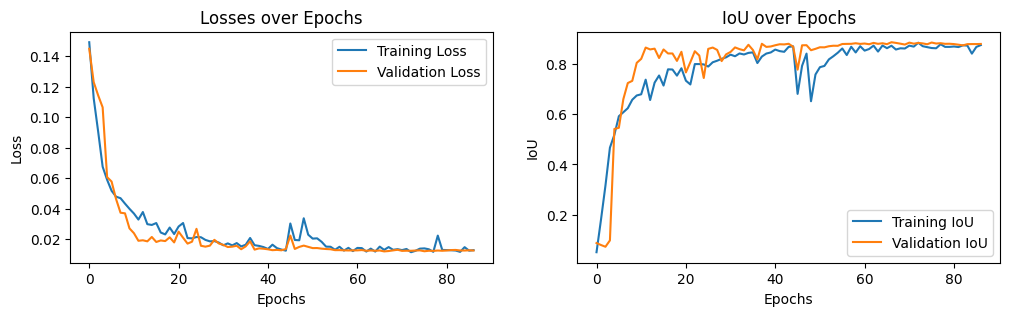

In [45]:
plot_loss_and_metrics(train_losses, train_ious, valid_losses, valid_ious)

In [47]:
torch.save(model.state_dict(), "unet-seed23_wDA&ESRx2_weights.pth")
torch.save(optimizer.state_dict(), "unet-seed23_wDA&ESRx2-optimizer_state.pth")


In [62]:
importlib.reload(S7_tools)
from S7_tools import compute_confusion_matrix_with_distributions, display_confusion_matrix_with_metrics_and_distributions

Test loader dataset size: 36
Batch size: 40, Total batches: 1
Processing batch 1/1: 36 images.
Batch 1 shapes - preds: torch.Size([36, 1, 512, 512]), masks: torch.Size([36, 1, 512, 512])
Flattened batch 1 shapes - preds: (9437184,), masks: (9437184,)
Final concatenated shapes - all_preds: (9437184,), all_masks: (9437184,)
----------------------------------------------------------------------
TP:616070	TN:8752295	FP:5481		FN:63338
----------------------------------------------------------------------


Accuracy:     0.9927	               (TP + TN) / (TP + TN + FP + FN)
Recall:       0.9068	                      TP / (TP + FN)
Specificity:  0.9994	                      TN / (TN + FP)
Precision:    0.9912	                      TP / (TP + FP)
F1-Score:     0.9471	    (2*precision*recall) / (precision + recall)
IoU:          0.8995	                      TP / (TP + FN + FP)





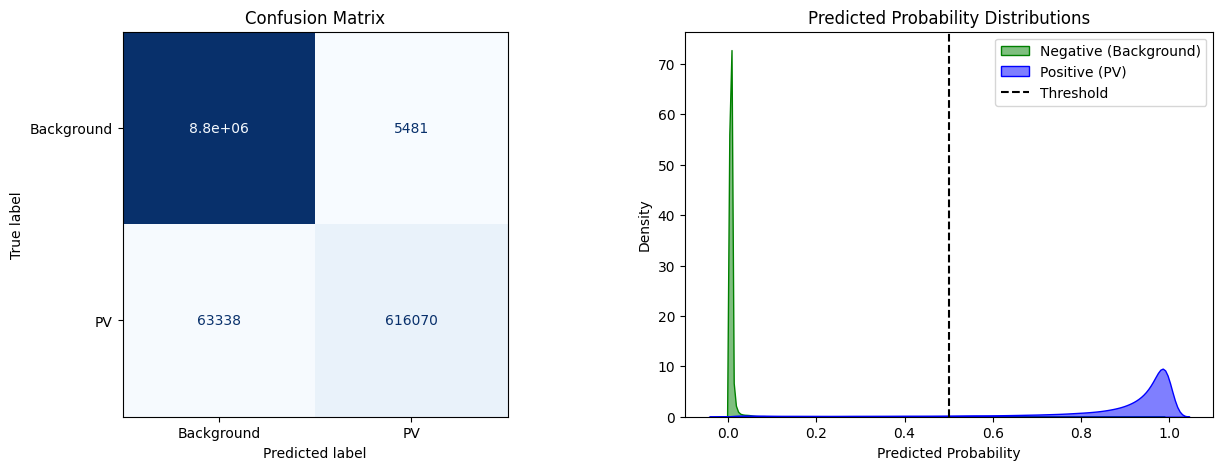

In [51]:
# Compute Confusion Matrix and plot
cm, pos_probs, neg_probs, nb_of_images_eval = compute_confusion_matrix_with_distributions(model, test_loader, DEVICE)
display_confusion_matrix_with_metrics_and_distributions(cm, pos_probs, neg_probs, nb_of_images_eval)

## 7.2- Super Resolution: Real-ESRGAN with 4x scale (upscale from 256x256 to 1024x1024)

In this section, we applied Bicubic Interpolation to all the images in the dataset, scaling them by a factor of 2, converting the original image size from 256×256 to 512×512. To avoid processing bottlenecks, we opted to pre-process the images by applying interpolation beforehand, rather than upscaling each image during the training loop.

In [40]:
# Function to extract the numeric value from filenames
def numeric_sort_key(filepath):
    # Extract numbers from the filename using a regular expression
    match = re.search(r'\d+', filepath)
    # Return the integer value of the number if found, otherwise 0
    return int(match.group()) if match else 0

# Get all the image and mask paths and sort them numerically
folder_data_train = sorted(
    glob.glob("../5-Data_Wrangling/data_split2esr_4x/train/input/*tif"),
    key=numeric_sort_key
)
folder_mask_train = sorted(
    glob.glob("../5-Data_Wrangling/data_split2esr_4x/train/labels/*tif"),
    key=numeric_sort_key
)

folder_data_val = sorted(
    glob.glob("../5-Data_Wrangling/data_split2esr_4x/val/input/*tif"),
    key=numeric_sort_key
)
folder_mask_val = sorted(
    glob.glob("../5-Data_Wrangling/data_split2esr_4x/val/labels/*tif"),
    key=numeric_sort_key
)

folder_data_test = sorted(
    glob.glob("../5-Data_Wrangling/data_split2esr_4x/test/input/*tif"),
    key=numeric_sort_key
)
folder_mask_test = sorted(
    glob.glob("../5-Data_Wrangling/data_split2esr_4x/test/labels/*tif"),
    key=numeric_sort_key
)

# Assign to variables
train_image_paths = folder_data_train[:]
val_image_paths = folder_data_val[:]
test_image_paths = folder_data_test[:]

train_mask_paths = folder_mask_train[:]
val_mask_paths = folder_mask_val[:]
test_mask_paths = folder_mask_test[:]


In [46]:
train_dataset = CustomDataset(train_image_paths, train_mask_paths, transform=augmentation_transform, band=model_band)
val_dataset = CustomDataset(val_image_paths, val_mask_paths, transform=simple_transform, band=model_band)
test_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=simple_transform, band=model_band)

In [48]:
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['solar_panel']
ACTIVATION = 'sigmoid'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = smp.Unet(
    in_channels = 4 if use_all_bands else 1, #4 for all bands
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [50]:
importlib.reload(S7_tools)
from S7_tools import WeightedBCELoss, BCEFocalNegativeIoULoss, compute_class_aware_iou, train_loop, plot_loss_and_metrics

In [52]:
# Following, we incorporate these steps before start training a new model. 
# This helps optimize GPU memory usage and avoid potential slowdowns during subsequent training runs.

# Clear GPU memory
torch.cuda.empty_cache()
gc.collect()

# Reset GradScaler
scaler = torch.amp.GradScaler('cuda')

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=0.0001,               
    weight_decay=1e-6        
    )

loss = BCEFocalNegativeIoULoss(alpha=0.8, gamma=2)

# Adjusts every 'step_size' epochs, decreasing by 'gamma'*100 %
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Reset the dataset loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=40, shuffle=False, num_workers=0)

In [54]:
train_losses, train_ious, valid_losses, valid_ious, _, _ = \
train_loop(model = model, 
           train_loader = train_loader, 
           valid_loader = valid_loader, 
           test_loader = test_loader, 
           optimizer = optimizer, 
           loss = loss, 
           scheduler = scheduler, 
           early_stopping_patience = 20, 
           early_stopping_min_delta = 0.0001, 
           model_filename = './models/Unet_wDA&ESR_4x_effb7.pth', 
           device = DEVICE)


Epoch: 0
Skipped batch with all all-background images.
Skipped batch with all all-background images.
Skipped batch with all all-background images.
Skipped batch with all all-background images.
Skipped batch with all all-background images.
Skipped batch with all all-background images.
Skipped batch with all all-background images.
Skipped batch with all all-background images.
Skipped batch with all all-background images.
Skipped batch with all all-background images.
Skipped batch with all all-background images.
Skipped batch with all all-background images.
Skipped batch with all all-background images.
Skipped batch with all all-background images.
Skipped batch with all all-background images.
Skipped batch with all all-background images.
Skipped batch with all all-background images.
Skipped batch with all all-background images.
Skipped batch with all all-background images.
Skipped batch with all all-background images.
Skipped batch with all all-background images.
Skipped batch with all a

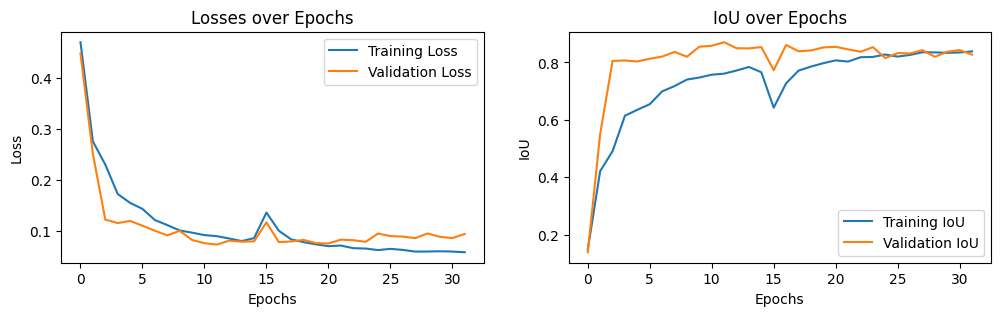

In [56]:
plot_loss_and_metrics(train_losses, train_ious, valid_losses, valid_ious)

In [58]:
torch.save(model.state_dict(), "unet-seed23_wDA&ESR_4x_weights.pth")
torch.save(optimizer.state_dict(), "unet-seed23_wDA&ESR_4x-optimizer_state.pth")

Test loader dataset size: 36
Batch size: 40, Total batches: 1
Processing batch 1/1: 36 images.
Batch 1 shapes - preds: torch.Size([36, 1, 1024, 1024]), masks: torch.Size([36, 1, 1024, 1024])
Flattened batch 1 shapes - preds: (37748736,), masks: (37748736,)
Final concatenated shapes - all_preds: (37748736,), all_masks: (37748736,)
----------------------------------------------------------------------
TP:2430020	TN:35020031	FP:11073		FN:287612
----------------------------------------------------------------------


Accuracy:     0.9921	               (TP + TN) / (TP + TN + FP + FN)
Recall:       0.8942	                      TP / (TP + FN)
Specificity:  0.9997	                      TN / (TN + FP)
Precision:    0.9955	                      TP / (TP + FP)
F1-Score:     0.9421	    (2*precision*recall) / (precision + recall)
IoU:          0.8905	                      TP / (TP + FN + FP)





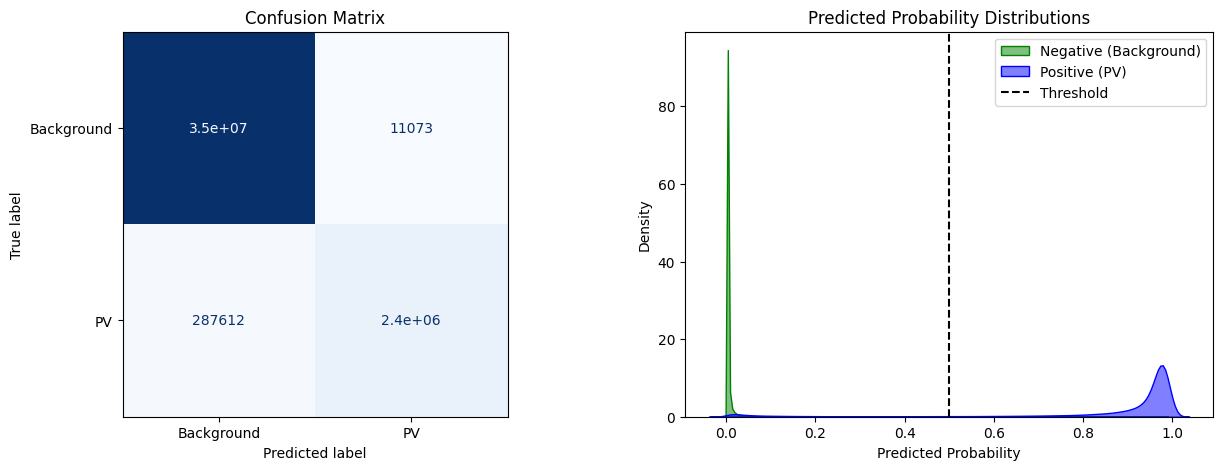

In [64]:
# Compute Confusion Matrix and plot
cm, pos_probs, neg_probs, nb_of_images_eval = compute_confusion_matrix_with_distributions(model, test_loader, DEVICE)
display_confusion_matrix_with_metrics_and_distributions(cm, pos_probs, neg_probs, nb_of_images_eval)

### Treating the high number of FN

### because of the high number of FN observed when we used the Super Resolution over the training set not changing the model hyperparameters, we will change on specific hyperparameter that can reduce the FN. In fact, we will change the weights for the jaccard loss componenent of our Loss function penalizing more the FN.

In [70]:
importlib.reload(S7_tools)
from S7_tools import WeightedBCELoss, BCEFocalNegativeIoULoss, compute_class_aware_iou, train_loop, plot_loss_and_metrics

In [72]:
# Following, we incorporate these steps before start training a new model. 
# This helps optimize GPU memory usage and avoid potential slowdowns during subsequent training runs.

# Clear GPU memory
torch.cuda.empty_cache()
gc.collect()

# Reset GradScaler
scaler = torch.amp.GradScaler('cuda')

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=0.0001,               
    weight_decay=1e-6        
    )

loss = BCEFocalNegativeIoULoss(alpha=0.8, gamma=2, jaccard_loss_pos_weight= 0.7, jaccard_loss_neg_weight= 0.3)

# Adjusts every 'step_size' epochs, decreasing by 'gamma'*100 %
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Reset the dataset loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=40, shuffle=False, num_workers=0)

In [ ]:
train_losses, train_ious, valid_losses, valid_ious, _, _ = \
train_loop(model = model, 
           train_loader = train_loader, 
           valid_loader = valid_loader, 
           test_loader = test_loader, 
           optimizer = optimizer, 
           loss = loss, 
           scheduler = scheduler, 
           early_stopping_patience = 20, 
           early_stopping_min_delta = 0.0001, 
           model_filename = './models/Unet_wDA&ESR_4x_effb7_v2.pth', 
           device = DEVICE)


Epoch: 0


## 4- Compare Results

Below are the results obtained:

![Model Results](sup_images/results_part2.png)

With Data Augmentation (Row 2): Data augmentation improved precision (0.9907) and specificity (0.9994) while significantly reducing false positives. However, it negatively impacted recall (0.8760) and overall balance, as reflected in the F1-Score (0.9298) and IoU (0.8689).

With Data Augmentation and Bicubic Interpolation (Row 3): Adding 2× Bicubic Interpolation (resulting in images 4 times larger) greatly improved recall (0.9723), F1-Score (0.9723), and IoU (0.9462), showcasing the model's enhanced ability to detect true positives. However, the number of false positives (FP) and false negatives (FN) is no longer directly comparable to previous rows due to the increased image size. This setup achieved the best overall balance between precision and recall.


